In [299]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [300]:
data = pd.read_csv('/content/spam.csv',encoding='ISO-8859-1')

In [301]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [302]:
data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)

In [303]:
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [304]:
data.columns = ['Target','Data']

In [305]:
data['Target'] = data['Target'].map({'ham': 0, 'spam': 1})

In [306]:
data.head()

,Target,Data
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [307]:
data.isna().sum()

Target    0
Data      0
dtype: int64

In [314]:
print((data['Target']==0).sum())
print((data['Target']==1).sum())

4825
747


In [315]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [316]:
stopword = set(stopwords.words('english'))
punctuations = set(string.punctuation)
# print(stopword)
print(punctuations)

{'%', '>', ':', '"', '*', '&', '}', '^', '-', '\\', '{', ')', '=', '#', '_', '+', '$', '?', '~', ';', '|', '(', '`', '<', '@', '!', '.', '/', '[', "'", ']', ','}


In [317]:
dic = {}
X = []
Y = data['Target'].values
ind = 0
for i in data['Data']:
  val = (word_tokenize(i))
  valf = [v.lower() for v in val if v not in punctuations ]
  # print(valf)
  # break
  for st in valf:
    if st not in dic:
      dic[st] = ind
      ind += 1
  maped = [dic[v] for v in valf]
  X.append(maped)


In [318]:
# print(dic)
# X = np.array(X)
# print(X.shape)
# print(Y.shape)

In [319]:
len(dic)

9414

In [320]:
def generator(x,y,batch_size=32,s=True):
  batches = int(np.ceil(len(y)/batch_size))
  if s:
     x,y = shuffle(x,y)
  for i in range(batches):
    end = min((i+1)*batch_size,len(y))
    x_b = x[i*batch_size:end]
    y_b = y[i*batch_size:end]
    maxi = max(len(r) for r in x_b)
    for j in range(len(x_b)):
      rem = maxi - len(x_b[j])
      pad = [0] * (rem)
      x_b[j] = pad + x_b[j]
    xf = torch.from_numpy(np.array(x_b)).long()
    yf = torch.from_numpy(np.array(y_b)).long()
    yield xf , yf



In [321]:
for i,j in generator(X,Y):
  print(i,i.shape)
  print("                ")
  print(j,j.shape)
  break

tensor([[   0,    0,    0,    0,    0,    0,    0, 7997, 3300, 3301, 1434, 3302,
          959,   81, 3303,  142, 3304,  273,   49,  187, 3305, 2384,   34, 3306,
         3307,   34,  660, 1689,  142, 3308, 3309],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,  833,   63,   66,   63,  253,  377],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,   63,  505, 2239,  103,  182],
        [   0,  204,   63,   64,   65,  135,  406, 1662,   82,   30,  263,  167,
          168,  169,   31, 8259,  562,    8,  158, 1870,   82,   63,   86, 2344,
          104,  461, 8260,  259,  282,   52, 2886],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,   11,   63, 

In [322]:
class LstmModel(nn.Module):
  def __init__(self,corpus_size,n_in,n_hidden,n_out,n_layers):
    super().__init__()
    self.V = corpus_size
    self.D = n_in
    self.M = n_hidden
    self.K = n_out
    self.L = n_layers
    self.emd = nn.Embedding(self.V,self.D)
    self.lstm = nn.LSTM(
        input_size = self.D,
        hidden_size= self.M,
        num_layers = self.L,
        batch_first = True
    )
    self.linear = nn.Linear(
        self.M, self.K
    )
  def forward(self,x):
    h0 = torch.zeros(self.L,x.size(0),self.M)
    a0 = torch.zeros(self.L,x.size(0),self.M)
    em_out = self.emd(x)
    lstm_out,_ = self.lstm(em_out,(h0,a0))
    o,_ = torch.max(lstm_out,axis=1)
    return self.linear(o)

In [323]:
lstm = LstmModel(len(dic),50,60,2,1)
def accuracy(outputs,targets):
  _,predicted = torch.max(outputs,axis=1)
  return torch.tensor((predicted==targets).sum().item()/len(targets))

In [324]:
def trainer(epochs,alpha,X_train,Y_train,X_test,Y_test,model):
  losses = []
  temp_losse = []
  acces = []
  temp_acce = []
  test_losses = []
  test_temp_losses = []
  test_acces = []
  test_temp_acces = []
  opt = torch.optim.Adam(model.parameters(),alpha)
  for ep in range(epochs):
     for inputs,targets in generator(X_train,Y_train):
       out = model(inputs)
      #  targets = targets.float()
       #long output need to convert into -> float32 for the cross entropy to work
      #  print(out.shape)
      #  print(targets.shape)
      #  break
       loss = F.cross_entropy(out,targets)
       acc = accuracy(out,targets)
       temp_losse.append(loss.item())
       temp_acce.append(acc.item())
       print(loss)
       loss.backward()
       opt.step()
       opt.zero_grad()
     for inputs,targets in generator(X_test,Y_test):
       out = model(inputs)
       loss = F.cross_entropy(out,targets)
       acc = accuracy(out,targets)
       test_temp_losses.append(loss.item())
       test_temp_acces.append(acc.item())
     losses.append(np.array(temp_losse).mean())
     acces.append(np.array(temp_acce).mean())
     test_losses.append(np.array(test_temp_losses).mean())
     test_acces.append(np.array(test_temp_acces).mean())

  # print(losses)
  return np.array(losses),np.array(test_losses) , np.array(acces) , np.array(test_acces)

In [325]:
N = len(X)
X_train , X_test = train_test_split(X,test_size=0.33)
Y_train , Y_test = train_test_split(Y,test_size=0.33)
print(N)
print(len(X_train),len(Y_train))
print(len(X_test),len(Y_test))
# Y_train = Y[:2*N/3]
# Y_test = Y[2*N/3:]

5572
3733 3733
1839 1839


In [326]:
losses,test_losses, acces,test_acces = trainer(50,0.01,X_train,Y_train,X_test,Y_test,lstm)

Streaming output truncated to the last 5000 lines.
tensor(0.1075, grad_fn=<NllLossBackward0>)
tensor(0.1084, grad_fn=<NllLossBackward0>)
tensor(0.0115, grad_fn=<NllLossBackward0>)
tensor(0.0167, grad_fn=<NllLossBackward0>)
tensor(0.1604, grad_fn=<NllLossBackward0>)
tensor(0.0534, grad_fn=<NllLossBackward0>)
tensor(0.0092, grad_fn=<NllLossBackward0>)
tensor(0.0279, grad_fn=<NllLossBackward0>)
tensor(0.0186, grad_fn=<NllLossBackward0>)
tensor(0.0260, grad_fn=<NllLossBackward0>)
tensor(0.0246, grad_fn=<NllLossBackward0>)
tensor(0.0500, grad_fn=<NllLossBackward0>)
tensor(0.0593, grad_fn=<NllLossBackward0>)
tensor(0.0626, grad_fn=<NllLossBackward0>)
tensor(0.0469, grad_fn=<NllLossBackward0>)
tensor(0.0214, grad_fn=<NllLossBackward0>)
tensor(0.0733, grad_fn=<NllLossBackward0>)
tensor(0.0734, grad_fn=<NllLossBackward0>)
tensor(0.0534, grad_fn=<NllLossBackward0>)
tensor(0.0401, grad_fn=<NllLossBackward0>)
tensor(0.1009, grad_fn=<NllLossBackward0>)
tensor(0.0587, grad_fn=<NllLossBackward0>)
ten

Text(0.5, 1.0, 'The Training Vs Testing Loss of the LSTM MODEL')

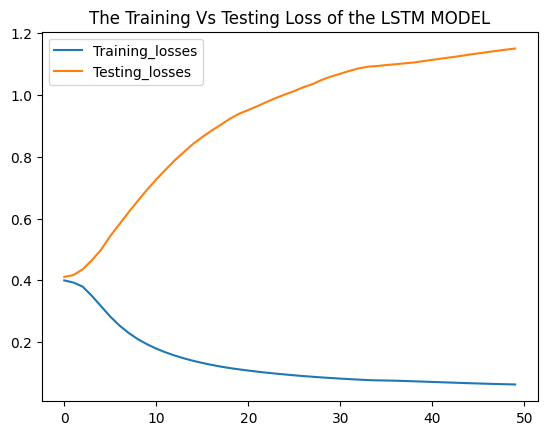

In [327]:
plt.plot(np.arange(len(losses)),losses,label='Training_losses')
plt.plot(np.arange(len(test_losses)),test_losses,label='Testing_losses')
plt.legend()
plt.title('The Training Vs Testing Loss of the LSTM MODEL')

Text(0.5, 1.0, 'The Training Accuracy VS Testing Accuracy of the LSTM MODEL')

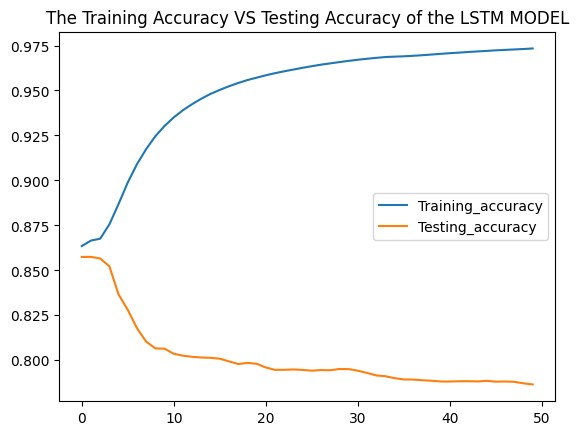

In [328]:
plt.plot(np.arange(len(acces)),acces,label='Training_accuracy')
plt.plot(np.arange(len(test_acces)),test_acces,label='Testing_accuracy')
plt.legend()
plt.title('The Training Accuracy VS Testing Accuracy of the LSTM MODEL')

In [330]:
print(acces[len(acces)-1])
print(test_acces[len(test_acces)-1])

0.9733447802372468
0.7865517243640177
